<a href="https://colab.research.google.com/github/Yas2020/GCP-VertexAI/blob/main/DemandForcast_XGBoost_VertexAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a XgBoost model with a `CustomJob` on VertexAI


# Overview: Creating custom training jobs on Vertex AI.

We use Vertex AI Python client library to train and deploy a custom regression model for demand forcasting and do a prediction.

### Dataset

The dataset used here is [sale-prediction dataset](https://www.kaggle.com/c/competitive-data-science-predict-future-sales) from Kaggle. I enjoyed exploring it, tried different ideas for modeling and learned a lot tackling the challenges it bring on. A regression xgboost model is trained to predicts sales at item-store level for a retailer for Nov, 2015 given the historical sale records from Jan, 2013 to Oct, 2015. Having extra memory from Large Machines on GCP allows more flexibilty for exploring. Given that the raw data has about 2.9M records which grows to about 11.9M rows after preparation as a time series, I decided to use Google Cloud resources for this project.   

### Objective

In this notebook, we build a custom model that requires a python package and then uses a pre-built Docker container from AI Platform on GCP. Using the AI Platform Python client library, we can also do a prediction on the deployed model if we want to. 

The steps performed include: 
- Create an AI Platform `CustomJob` resource for training a model.
- Train the model.
- Retrieve and load the model (artifacts).
- View the model evaluation and performance on test data.



## Installation

Install the latest (preview) version of AI Platform Python client library.

In [ ]:
! pip3 install -U google-cloud-aiplatform

     |████████████████████████████████| 1.9MB 6.9MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 112kB 23.8MB/s 
ERROR: google-cloud-storage 1.38.0 has requirement google-cloud-core<2.0dev,>=1.4.1, but you'll have google-cloud-core 1.0.3 which is incompatible.
ERROR: google-cloud-storage 1.38.0 has requirement google-resumable-media<2.0dev,>=1.2.0, but you'll have google-resumable-media 0.4.1 which is incompatible.
  Found existing installation: google-cloud-storage 1.18.1
    Uninstalling google-cloud-storage-1.18.1:
      Successfully uninstalled google-cloud-storage-1.18.1


Install the Google `cloud-storage` library as well.

In [ ]:
! pip3 install google-cloud-storage

     |████████████████████████████████| 81kB 3.8MB/s 
ERROR: google-cloud-bigquery 1.21.0 has requirement google-resumable-media!=0.4.0,<0.5.0dev,>=0.3.1, but you'll have google-resumable-media 1.3.0 which is incompatible.
  Found existing installation: google-resumable-media 0.4.1
    Uninstalling google-resumable-media-0.4.1:
      Successfully uninstalled google-resumable-media-0.4.1
  Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3


In [ ]:
pip install 'xgboost==1.1'

     |████████████████████████████████| 127.6MB 82kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


### Restart the Kernel

Once you've installed the AI Platform Python client library, you need to restart the notebook kernel so it can find the packages.

In [ ]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform API, Compute Engine API and Container Registry API.](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,containerregistry.googleapis.com)

4. Enter your project ID in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.



#### Project ID

**If you don't know your project ID**, you might be able to get your project ID using `gcloud` command by executing the second cell below.

In [ ]:
PROJECT_ID = "myproject051321"  # @param {type:"string"}

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

In [ ]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

`REGION` variable is used for operations
throughout the rest of this notebook.  Below are regions supported for AI Platform. We choose the region closest to you. 

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You must not use a multi-regional bucket for training with AI Platform. Not all regions provide support for all AI Platform services. For the latest support per region, see [the AI Platform locations documenation](https://cloud.google.com/ai-platform-unified/docs/general/locations)

In [ ]:
REGION = "us-central1"  # @param {type: "string"}

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append onto the name of resources which will be created in this tutorial.

In [ ]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your Google Cloud account. This provides access
# to your Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# If on AI Platform Notebooks, then don't execute this code
if not os.path.exists("/opt/deeplearning/metadata/env_version"):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this tutorial in a notebook locally, replace the string
    # below with the path to your service account key and run this cell to
    # authenticate your Google Cloud account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS your_path_to_credentials.json

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

We upload a Python package
containing the training code to a Cloud Storage bucket. AI Platform runs
the code from this package. Model will be saved later. We can then
create an AI Platform `Endpoint` based on this output in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets. 

In [ ]:
BUCKET_NAME = "myproject1051321"  # @param {type:"string"}

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "ucaip-custom-" + TIMESTAMP

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
#! gsutil mb -l $REGION gs://$BUCKET_NAME

Finally, validate access to your Cloud Storage bucket by examining its contents:

In [ ]:
! gsutil ls -al gs://$BUCKET_NAME

      6168  2021-06-07T02:06:53Z  gs://myproject1051321/trainer_xgb.tar.gz#1623031613252266  metageneration=1
                                 gs://myproject1051321/custom_job_20210516013132/
                                 gs://myproject1051321/data/
TOTAL: 1 objects, 6168 bytes (6.02 KiB)


### Import libraries and define constants

#### Import AI Platform Python client library

Import the AI Platform Python client library into your Python environment.

In [ ]:
import os
import sys
import time

from google.cloud.aiplatform import gapic as aip
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

#### AI Platform constants

Set some constants for AI Platform:

- `API_ENDPOINT`: The AI Platform API service endpoint for the Job, Model, Endpoint, and Prediction services.
- `PARENT`: The AI Platform location root path for dataset, model and endpoint resources.

In [ ]:
# API service endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

# AI Platform (Unified) location root path for your dataset, model and endpoint resources
PARENT = "projects/" + PROJECT_ID + "/locations/" + REGION

In [ ]:
PARENT

'projects/myproject051321/locations/us-central1'

In [ ]:
#TRAIN_GPU, TRAIN_NGPU = (aip.AcceleratorType.NVIDIA_TESLA_K80, 1)
TRAIN_GPU, TRAIN_NGPU = (None, None)
DEPLOY_GPU, DEPLOY_NGPU = (None, None)

#### Container (Docker) image

Next, set the Docker container images for training and prediction.


 - XGBoost
   - `gcr.io/cloud-aiplatform/training/xgboost-cpu.1-1`
   - `gcr.io/cloud-aiplatform/prediction/xgboost-cpu.1-1`
 
AI Platform frequently adds new training and prediction container images. For the latest list, see [Pre-built containers for training](https://cloud.google.com/ai-platform-unified/docs/training/pre-built-containers) and [Pre-built containers for prediction](https://cloud.google.com/ai-platform-unified/docs/predictions/pre-built-containers)

In [ ]:
TRAIN_IMAGE = "gcr.io/cloud-aiplatform/training/xgboost-cpu.1-1"
DEPLOY_IMAGE = "gcr.io/cloud-aiplatform/prediction/xgboost-cpu.1-1"

print("Training:", TRAIN_IMAGE)
print("Deployment:", DEPLOY_IMAGE)

Training: gcr.io/cloud-aiplatform/training/xgboost-cpu.1-1
Deployment: gcr.io/cloud-aiplatform/prediction/xgboost-cpu.1-1


#### Machine Type

Next, set the machine type to use for training and prediction.

- Set the variables `TRAIN_COMPUTE` and `DEPLOY_COMPUTE` to configure the compute resources for the VMs you will use for training and prediction.
 - `machine type`
     - `n1-standard`: 3.75GB of memory per vCPU.
     - `n1-highmem`: 6.5GB of memory per vCPU
     - `n1-highcpu`: 0.9 GB of memory per vCPU
 - `vCPUs`: number of \[2, 4, 8, 16, 32, 64, 96 \]
  
*Note: The following is not supported for training*
 
 - `standard`: 2 vCPUs
 - `highcpu`: 2, 4 and 8 vCPUs
 
*Note: You may also use n2 and e2 machine types for training and deployment, but they do not support GPUs*

We choose `n1-highmem-8` for this project.

In [ ]:
MACHINE_TYPE = "n1-highmem"
VCPU = "8"
TRAIN_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", TRAIN_COMPUTE)

MACHINE_TYPE = "n1-highmem"
VCPU = "8"
# If you want to deploy your model, specify its machine:
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Deploy machine type", DEPLOY_COMPUTE)

Train machine type n1-highmem-8
Deploy machine type n1-highmem-8


## Clients

The AI Platform Python client library works as a client/server model. On your side, the Python script, you will create a client that sends requests and receives responses from the server -- AI Platform.

Use several clients in this tutorial, so you will set them all up upfront.

- Job Service for custom jobs.
- Model Service for managed models.
- Endpoint Service for deployment.
- Prediction Service for serving.

In [ ]:
# client options same for all services
client_options = {"api_endpoint": API_ENDPOINT}
predict_client_options = {"api_endpoint": API_ENDPOINT}

def create_job_client():
    client = aip.JobServiceClient(client_options=client_options)
    return client

def create_model_client():
    client = aip.ModelServiceClient(client_options=client_options)
    return client

def create_endpoint_client():
    client = aip.EndpointServiceClient(client_options=client_options)
    return client

def create_prediction_client():
    client = aip.PredictionServiceClient(client_options=predict_client_options)
    return client

clients = {}
clients["job"] = create_job_client()
clients["model"] = create_model_client()
clients["endpoint"] = create_endpoint_client()
clients["prediction"] = create_prediction_client()

for client in clients.items():
    print(client)

('job', <google.cloud.aiplatform_v1.services.job_service.client.JobServiceClient object at 0x7f2cc79cb210>)
('model', <google.cloud.aiplatform_v1.services.model_service.client.ModelServiceClient object at 0x7f2cc79cb250>)
('endpoint', <google.cloud.aiplatform_v1.services.endpoint_service.client.EndpointServiceClient object at 0x7f2cc79cb290>)
('prediction', <google.cloud.aiplatform_v1.services.prediction_service.client.PredictionServiceClient object at 0x7f2ccc480d90>)


## Prepare your `CustomJob` specification

Now that your clients are ready, your first step is to create a `CustomJob` specification for your custom training job.

### Define a container specification

Let's first start by defining a job name and then a container specification:

- `JOB_NAME`: A unique name for your custom training job. For convenience, append a timestamp to make the name unique.
- `MODEL_DIR`: A location in your Cloud Storage bucket for storing the model artificats.
- `image_uri`: The location of the container image in Artifact Registry, Container Registry, or Docker Hub. This can be either a Google Cloud pre-built image or your own container image.
- `--model-dir`: A command-line parameter to the container indicating the location to store the model.

### Examine the training package

#### Package layout

Before you start the training, look at how a Python package is assembled for a custom training job. When unarchived, the package contains the following directory/file layout.

- PKG-INFO
- README.md
- setup.cfg
- setup.py
- trainer
  - \_\_init\_\_.py
  - task.py

The files `setup.cfg` and `setup.py` are the instructions for installing the package into the operating environment of the Docker container.

The file `trainer/task.py` is the Python script for executing the `CustomJob`. *Note*, when we referred to it in the worker pool specification, we replace the directory slash with a dot (`trainer.task`) and dropped the file suffix (`.py`). A sample for building the python package for training a xgboost base can be found [here](https://github.com/GoogleCloudPlatform/ai-platform-samples/tree/master/training/xgboost/structured/base)

#### Package Assembly

In the following cells, we will assemble the training package.

In [ ]:
# Make folder for Python training script
! rm -rf custom
! mkdir custom

# Add package information
! touch custom/README.md

setup_cfg = "[egg_info]\n\
tag_build =\n\
tag_date = 0"
! echo "$setup_cfg" > custom/setup.cfg

# Use gscfs module to enable pandas to read from GCS
setup_py = "import setuptools\n\
# Requires TensorFlow Datasets\n\
setuptools.setup(\n\
                 install_requires=[\n\
                'pip==21.1.2',\n\
                'pandas==1.1.5',\n\
                'xgboost==1.1',\n\
                'gcsfs',\n\
                'cloudml-hypertune'],\n\
                packages=setuptools.find_packages())"
! echo "$setup_py" > custom/setup.py

pkg_info = "Metadata-Version: 1.0\n\
Name: UNKNOWN\n\
Version: 0.0.0\n\
Summary: Demostration training script\n\
Home-page: www.google.com\n\
Author: Google\n\
Author-email: UNKNOWN\n\
License: Public\n\
Description: Demo\n\
Platform: AI Platform (Unified)"
! echo "$pkg_info" > custom/PKG-INFO

# Make the training subfolder
! mkdir custom/trainer
! touch custom/trainer/__init__.py

#### Task.py contents

In the next cell, the contents of the training script task.py will be written. In summary, the training script does the following:

- Gets the directory where to save the model artifacts from the command line (`--model_dir`).
- Downloads dataset from Kaggle.
- Loads the raw data and builds a time series dataset from it. 
- Trains a XGBoost model according to the arguments
- Saves the trained model to the specified model directory.

In preparation of the dataset, I learned from [this notebook](https://www.kaggle.com/dlarionov/feature-engineering-xgboost/notebook) from Kaggle. In particular, the way the string features are encoded from Russian language and also other feature are from this notebook. Without this insight from Russian language, I would have to tokenize the text and pick the mose important one later after analyzing the trained model and related features. This would lead to dropping a many of those encoded words.  However, the structure of the data during and after processing is significantly different from the mentioned notebook.

***Note***: In definition of function `create_dataset`, we add one dummy record for month number 35, with any arbitrary (item_id, shop_id) and any price or item_cnt_day values. The values do not matter as they wont be used anyways. When we later pivot the table, this single record automatically gets expanded to the whole set of (item_id, shop_id) pairs existed in the train set for the month number 35. This part of data will form our **test set** later. 

In [ ]:
%%writefile custom/trainer/model.py

import xgboost as xgb
import logging
import os
import hypertune
import numpy as np
from trainer import utils
import pickle

# We can submit a hyperparameter job as we will see later. 
HYPERPARAMETER_TUNING = False

def train_xgb(data, arguments, output_path):
    x_train, y_train, x_val, y_val = data
    dtrain = xgb.DMatrix(data=x_train, label=y_train)
    # Set early_stopping if there is any validation data

    params = {'eval_metric': ['rmse', 'mae'],
              'learning_rate': arguments.learning_rate,
              'eta': arguments.eta,
              'max_depth': arguments.max_depth,
              'alpha': arguments.alpha,
              'verbosity': 0,
              'min_child_weight': arguments.min_child_weight,
              'subsample': arguments.subsample,
              #'sampling_method': 'gradient_based',
              #'colsample_bytree': 0.9,
              #'colsample_bylevel': 1,
              'tree_method': 'hist',
              'seed': 0,
              'disable_default_eval_metric': 1,
              'num_parallel_tree': arguments.num_parallel_tree,
            }
    
    # Train the model with specified parameters
    if not x_val.empty:
          results = {} 
          dval = xgb.DMatrix(data=x_val, label=y_val)
          evals=[(dtrain, 'dtrain'), (dval, 'dval')]
          model = xgb.train(params, 
                            dtrain, 
                            num_boost_round=arguments.num_boost_round,
                            evals=evals,
                            early_stopping_rounds = 5,
                            evals_result=results
                            )
          logging.info('Scores: %s', results)
    else:
          model = xgb.train(params, 
                            dtrain, 
                            num_boost_round=arguments.num_boost_round,
                            )
          
    temp_file = '/tmp/modelfile'
    # Use save_model method of a xgb booster or pickle the model
    # model.save_model(temp_file)
    pickle.dump(model, open(temp_file, 'wb'))
    model_output_path = os.path.join(output_path, 'model')
    utils.copy_file(temp_file, model_output_path)

    if HYPERPARAMETER_TUNING:

        # The default name of the metric is training/hptuning/metric.
        # We recommend that you assign a custom name
        # The only functional difference is that if you use a custom name,
        # you must set the hyperparameterMetricTag value in the
        # HyperparameterSpec object in the job request to match the chosen name
        hpt = hypertune.HyperTune()
        hpt.report_hyperparameter_tuning_metric(
            hyperparameter_metric_tag='my_metric_tag',
            metric_value=np.mean(results['dval']['rmse']),
            global_step=1000)


Writing custom/trainer/model.py


In [ ]:
%%writefile custom/trainer/task.py
import pandas as pd
import logging
import pickle
import sys
import os
import numpy as np
import gcsfs
from sklearn import model_selection
import hypertune
from trainer import model
from trainer import utils


BUCKET_NAME = 'myproject1051321'
MODEL_DIR = 'gs://myproject1051321/custom_job_20210516013132'

print('Python Version = {}'.format(sys.version))


def main():
    arguments = utils._parse_args()
    # Load and preprocess data
    train, items, shops, cats = utils.preprocess_data(BUCKET_NAME)
    logging.info('intial preparation was done')
    data = utils.create_data(train, items, shops, cats, arguments)
    #data = data[data.month_num_pred>11]
    test = data[data.month_num_pred==34]    # November, 2015 for test
    logging.info('Length of test set is:' + str(len(test)))
    logging.info('Final data is ready...')
    if arguments.split_to_train_val:
        logging.info('data is being splitted...')
        # Use the last month of data as for validation
        #train = data[(data.month_of_pred<10)|(data.year_of_pred!=2015)]
        train = data[data.month_num_pred<33]
        # October, 2015 for validation
        val = data[data.month_num_pred==33] 
        y_val = val['label']
        x_val = val.drop('label', axis=1)
    else:
        logging.info('data is not splitted...')
        train = data[data.month_num_pred<34]
        x_val, y_val = pd.DataFrame(), pd.DataFrame()
    x_train = train.drop('label', axis=1)
    y_train = train['label']
    x_test = test.drop('label', axis=1)
    # Save the test set for later prediction
    x_test.to_pickle(MODEL_DIR + '/test.pkl')
    # Pass the final data to xgboost for training and save the model
    data = x_train, y_train, x_val, y_val
    model.train_xgb(data, arguments, MODEL_DIR)

if __name__ == '__main__':
    main()

Writing custom/trainer/task.py


In [ ]:
%%writefile custom/trainer/utils.py

import tensorflow as tf
import ntpath
import os
import argparse
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import gc
import logging


def copy_file(old_path, new_path):
    """Copy the file from old_path to new_path
    The paths can be local or on GCS
    Args:
      old_path: (string) original file location
      new_path: (string) new location and name for the file to be copied to
    Returns:
      None
    """

    # Make sure the local nested directory already exists:
    out_dir = ntpath.split(new_path)[0]
    if not (out_dir.startswith('gs://') and os.path.exists(out_dir)):
        os.makedirs(out_dir)
    tf.io.gfile.copy(old_path, new_path, overwrite=True)


def _parse_args():
    """Parses command line arguments and pass them to different components of the python script
    Returns: parser object
      None
    """

    parser = argparse.ArgumentParser() 
    parser.add_argument('--num_boost_round', dest='num_boost_round',
                        default=10, type=int,
                        help='num_boost_round') 
    parser.add_argument('--learning_rate', dest='learning_rate',
                        default=0.05, type=float,
                        help='learning_rate')
    parser.add_argument('--eta', dest='eta',
                        default=0.3, type=float,
                        help='eta')
    parser.add_argument('--max_depth', dest='max_depth',
                        default=5, type=int,
                        help='max_depth')
    parser.add_argument('--min_child_weight', dest='min_child_weight',
                        default=1, type=int,
                        help='min_child_weight')
    parser.add_argument('--alpha', dest='alpha',
                        default=1.0, type=float,
                        help='alpha')
    parser.add_argument('--subsample', dest='subsample',
                        default=0.5, type=float,
                        help='subsample')
    parser.add_argument('--num_parallel_tree', dest='num_parallel_tree',
                        default=1, type=int,
                        help='num_parallel_tree')
    parser.add_argument('--split_to_train_val', dest='split_to_train_val',
                        default=1, type=int,
                        help='split_to_train_val')
    parser.add_argument('--lag_length', dest='lag_length',
                        default=6, type=int,
                        help='lag_lenth')
    parser.add_argument('--shift', dest='shift',
                        default=1, type=int,
                        help='shift')
    
    return parser.parse_args()


def preprocess_data(BUCKET_NAME):
    '''Loads data from GCS - 
    Removes outliers, 
    Replaces corrupted values, 
    Parses string columns and encode them
    Returns: 
        Pandas DataFrame'''

    # Read required data from GCS - It will be dowloaded to GCS from Kaggle platform later in following cells
    train = pd.read_csv('gs://{}/data/sales_train.csv.zip'.format(BUCKET_NAME), parse_dates=['date'], dayfirst=True)
    items = pd.read_csv('gs://{}/data/items.csv.zip'.format(BUCKET_NAME))
    shops = pd.read_csv('gs://{}/data/shops.csv'.format(BUCKET_NAME))
    cats = pd.read_csv('gs://{}/data/item_categories.csv'.format(BUCKET_NAME))

    # Remove outliers
    train = train[train.item_price<100000]
    train = train[train.item_cnt_day<1001]

    # Fill in for negative prices
    median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
    train.loc[train.item_price<0, 'item_price'] = median

    # Handle string data: split shop names to city name plus the rest
    #                     split category name into types and subtypes for items

    shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
    shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
    shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'

    shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
    shops = shops[['shop_id','city_code']]

    cats['split'] = cats['item_category_name'].str.split('-')
    cats['type'] = cats['split'].map(lambda x: x[0].strip())
    cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
    
    # If subtype is nan then type
    cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
    cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
    cats = cats[['item_category_id','type_code', 'subtype_code']]
    
    # We wont make use of item names. So drop that column.
    items.drop(labels='item_name', axis=1, inplace=True)

    # Remove possible duplicates
    train.drop_duplicates(inplace=True)
    items.drop_duplicates(inplace=True)
    shops.drop_duplicates(inplace=True)
    cats.drop_duplicates(inplace=True)

    # we wont need daily date column as we will work with month number instead
    train.drop('date', axis=1, inplace=True)

    return train, items, shops, cats
    

def yer(x):
    '''A untility function
    Input: number of month from 0 to 33
    Returns: year oo the month ranging from 2013 to 2015'''

    if x<12: return 2013
    elif x<24: return 2014
    else: return 2015



def prep_dataset(data, lag_length, lag_name, lags=None, with_label=True):
    '''Creates lags of given names and a series of rows of data, each aiming 
    to target a label, which is item count in a month.'''

    columns = []
    # Column names
    lag_title = ['{}_{}'.format(lag_name, i) for i in range(lag_length,0,-1)]
    columns.extend(['shop_id', 'item_id'])
    columns.extend(lag_title)
    columns.extend(['month_of_pred', 'year_of_pred'])
    if with_label: columns.extend(['label'])
    prep_data = pd.DataFrame()
    length = data.shape[0]
    n = length - lag_length
    for i in range(0,n):
        df1 = pd.DataFrame(data.T.reset_index()[['shop_id', 'item_id']].values, columns=['shop_id', 'item_id'])
        # Lag features are attached to (item_id, shop_id) pairs 
        df1 = pd.concat([df1, pd.DataFrame(data[length-1-i-lag_length: length-1-i].T.values, dtype='float16')], axis=1, ignore_index=True)
        # Create month and year of the label being predicted - attach it to df1
        df2 = pd.DataFrame({
                            'month_of_pred': [data[length-i-1: length-i].index.values[0]%12+1]*df1.shape[0],
                            'year_of_pred': [yer(data[length-i-1: length-i].index.values[0])]*df1.shape[0]
                            }, dtype='int16')
        # Add label only for item_cnt records
        if with_label:
            df3 = pd.DataFrame({'label':data[length-i-1: length-i].T.values.reshape(-1)},dtype='float16')
            prep_data = prep_data.append(pd.concat([df1, df2, df3], axis=1, ignore_index=True))
        else: 
            prep_data = prep_data.append(pd.concat([df1, df2], axis=1, ignore_index=True))
        
    prep_data.columns = columns
    if lags:
       drop = ['{}_{}'.format(lag_name, i) for i in lags]
       prep_data.drop(drop, axis=1, inplace=True)
    return prep_data

def pivot(data, values, index, columns):
    '''Pivot the input data around values indexed by month (0-33) . 
    the columns are the multi-index of item_id and shop_id'''

    return pd.pivot_table(data, values=[values], index=index, columns=columns,)[values]



def create_data(train, items, shops, cats, arguments):
      '''Input: raw data consisting of dataframes train, items, shops and categories.
      Return: final time series data to be fed into the model'''
      
      lag_length = arguments.lag_length
      
      # This additional row (a dummy record) will later trigger building our test set as we move along.
      train = train.append(pd.DataFrame([[34, 25, 2552, 0.0, 0.0]], columns=list(train.columns)))


      # Building the base data for item count sale records - We downsample by aggregating target records to the monthly level   
      # Clip the sale record as instructed by competition evaluation rule
      data_cnt = train.groupby(['date_block_num','shop_id', 'item_id'])['item_cnt_day'].sum().clip(0,20)
      data_cnt = data_cnt.reset_index()

      data = pivot(data_cnt, 'item_cnt_day', 'date_block_num', ['shop_id', 'item_id'])
      data = data.fillna(0.0)
      data_cnt = data.stack(['item_id', 'shop_id']).reset_index()
      data_cnt.rename(columns={0: 'item_cnt_month'}, inplace=True)

      data_cnt = data_cnt.merge(items, how='left', on='item_id')
      data_cnt = data_cnt.merge(shops, how='left', on='shop_id')
      data_cnt = data_cnt.merge(cats, how='left', on='item_category_id')

      # We now start to gradually build the dataset from low to high granularity

      # Dataset I - Item Count-monthly
      data = pivot(data_cnt, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      Merged = prep_dataset(data, lag_length, lag_name='cnt_shop_item', with_label=True)

      Merged = pd.merge(Merged, items, how='left', on='item_id')
      Merged = pd.merge(Merged, cats, how='left', on='item_category_id')
      Merged = pd.merge(Merged, shops, how='left', on='shop_id')

      # Downcast to save memory
      Merged = Merged.astype({'shop_id': 'int8',
                              'item_id': 'int16',
                              'month_of_pred':'int8',
                              'year_of_pred':'int16',
                              'label':'float16',
                              'item_category_id':'int8',
                              'city_code':'int8',
                              'subtype_code':'int8',
                              'type_code':'int8'
                              })
            
      # Part II
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
      data = data.groupby(['date_block_num']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date', with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part III
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_item', with_label=False)
      
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
      
      # Part IV 
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'shop_id']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_shop', with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part V
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'item_category_id']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_item_cat', with_label=False)
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
      
      # Part VI
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat', lags=[7,8,9], with_label=False)
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part VII
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'shop_id', 'type_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat_type', lags=[7,10,11], with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part VIII
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'shop_id', 'subtype_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_shop_cat_subtype', lags=[7,8,9,10,11], with_label=False)
      
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part IX
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'city_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_city', lags= [9,10,11,12], with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part X
      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_item_city', lags=[6,7,8,9,10,11,12], with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part XI
      # data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'city_code'])['item_cnt_month']
      # data = data.groupby(['date_block_num', 'item_id', 'city_code']).transform('mean').reset_index()
      # data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      # data = prep_dataset(data, lag_length, lag_name='cnt_date_item_city', with_label=False)

      # Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part XII

      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'type_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'type_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_type', lags=[3,4,11,12], with_label=False)

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part XIII

      data = data_cnt.set_index(['date_block_num', 'item_id', 'shop_id', 'subtype_code'])['item_cnt_month']
      data = data.groupby(['date_block_num', 'subtype_code']).transform('mean').reset_index()
      data = pivot(data, 'item_cnt_month', 'date_block_num', ['shop_id', 'item_id'])
      data = prep_dataset(data, lag_length, lag_name='cnt_date_subtype', with_label=False)

      del data_cnt

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Base data for price records

      data_price = train.groupby(['date_block_num','shop_id', 'item_id'])['item_price'].mean() #Average price in month at item-shop level
      data_price = data_price.reset_index()
      data = pivot(data_price, 'item_price', 'date_block_num', ['shop_id', 'item_id'])
      data = data.ffill()
      data = data.bfill()
      data_price = data.stack(['item_id', 'shop_id']).reset_index()
      data_price = data_price.merge(items, how='left', on='item_id')
      data_price.rename(columns={0:'avg_price_month'}, inplace=True)

      # Release some memory
      del train
      del items
      del shops
      del cats
      
      # Part XIV 

      data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
      data = data.groupby(['item_id']).transform('mean').reset_index()
      avg_item_price_whole_data = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

      data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
      data = data.groupby(['date_block_num', 'item_id']).transform('mean').reset_index()
      avg_item_price_monthly = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])

      data = (avg_item_price_monthly - avg_item_price_whole_data)/avg_item_price_whole_data

      del avg_item_price_monthly
      del avg_item_price_whole_data
      gc.collect()

      data = prep_dataset(data, lag_length, lag_name='Avg_price_item', with_label=False)
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      # Part XV

      data = data_price.set_index(['date_block_num', 'item_id', 'shop_id', 'item_category_id'])['avg_price_month']
      data = data.groupby(['date_block_num', 'shop_id', 'item_category_id']).transform('sum').reset_index()
      price_cat_shop = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])
      
      data = data_price.set_index(['date_block_num', 'item_id', 'shop_id'])['avg_price_month']
      data = data.groupby(['date_block_num', 'shop_id', 'item_id']).transform('mean').reset_index()
      price_item_shop = pivot(data, 'avg_price_month', 'date_block_num', ['shop_id', 'item_id'])
      data = price_item_shop/price_cat_shop
      
      del price_cat_shop

      data = prep_dataset(data, lag_length, lag_name='item_price_percnt',lags=[7,8,9,10,11], with_label=False)
      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])
      
      # Part XVI

      diff_price = price_item_shop - price_item_shop.shift(1)
      data = diff_price[1:]/price_item_shop.shift(1)
      data = data.fillna(0.0)
      data = prep_dataset(data, lag_length, lag_name='item_price_discount', lags=[2,3,4,5,6,7,8,9,10,11,12], with_label=False)

      del diff_price
      del data_price
      del price_item_shop
      gc.collect()

      Merged = pd.merge(Merged, data, how='left', on=['year_of_pred', 'month_of_pred', 'shop_id', 'item_id'])

      #Add days in the month of prediction- and, number of month of prediction
      my = pd.concat([pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2013]*12}),
                      pd.DataFrame({'month_of_pred': np.arange(1,13),'year_of_pred' : [2014]*12}),
                      pd.DataFrame({'month_of_pred': np.arange(1,12),'year_of_pred' : [2015]*11})],
                                    axis=0, ignore_index=True)
      my['days'] = my.apply(lambda x:pd.Timestamp(x[1],x[0],1,0).days_in_month, axis=1)
      my = my.reset_index().rename(columns={'index':'month_num_pred'},)
      Merged = pd.merge(Merged, my, how='left', on=['month_of_pred', 'year_of_pred'])

      #drop = ['type_code', 'year_of_pred']
      #Merged.drop(drop, axis=1, inplace=True)

      return Merged


Writing custom/trainer/utils.py


#### Download data from Kaggle

To download data from Kaggle platform, we use Kaggle API via command line. However, for this to work, you need to have a `kaggle.json` file ready in the working directory. This file can be generated using your kaggle account.

In [ ]:
%%shell
pip install kaggle --upgrade -q
mkdir -p /root/.kaggle
cp ./kaggle.json /root/.kaggle/
kaggle competitions download -q competitive-data-science-predict-future-sales -p ./data/

#### Store training script and data on your Cloud Storage bucket

Next, package the training folder into a compressed tarball, and then store it in your Cloud Storage bucket.

In [ ]:
! rm -f custom.tar custom.tar.gz
! tar cvf custom.tar custom
! gzip custom.tar
! gsutil cp custom.tar.gz gs://$BUCKET_NAME/trainer_xgb.tar.gz
! gsutil -m cp -r ./data gs://$BUCKET_NAME/data

custom/
custom/README.md
custom/setup.py
custom/PKG-INFO
custom/trainer/
custom/trainer/model.py
custom/trainer/__init__.py
custom/trainer/utils.py
custom/trainer/task.py
custom/setup.cfg
Copying file://custom.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  6.0 KiB/  6.0 KiB]                                                
Operation completed over 1 objects/6.0 KiB.                                      
Copying file://./data/sample_submission.csv.zip [Content-Type=application/zip]...
Copying file://./data/sales_train.csv.zip [Content-Type=application/zip]...
Copying file://./data/item_categories.csv [Content-Type=text/csv]...
Copying file://./data/shops.csv [Content-Type=text/csv]...
Copying file://./data/test.csv.zip [Content-Type=application/zip]...
Copying file://./data/items.csv.zip [Content-Type=application/zip]...
/ [6/6 files][ 15.1 MiB/ 15.1 MiB] 100% Done                                    
Operation completed over 6 objects/15.1 MiB.                                  

## Train the model:

There are two ways you can train a custom model using a container image:

- **Use a an AI Platform pre-built container**. If you use a pre-built container, you will additionally specify a Python package to install into the container image. This Python package contains your code for training a custom model.

- **Use your own custom container image**. If you use your own container, the container needs to contain your code for training a custom model.


We will train our model using a pre-built container. We need to update the worker pool specification by adding a description for `python_package_spec`. This section will tell the custom job the Python training package to install and which Python module to invoke, along with command line arguments for the Python module.

The Python package specification contains the following fields:

-`executor_image_spec`: This is the Docker image which is configured for your custom training job. You will continue to use the same one we used earlier for demonstration.

-`package_uris`: This is a list of the locations (URIs) of your Python training packages to install on the provisioned instance. The locations need to be in a Cloud Storage bucket. These can be either individual Python files or a zip (archive) of an entire package. In the later case, the job service will unzip (unarchive) the contents into the Docker container.

-`python_module`: The Python module (script) to invoke for running the custom training job. In this example, you will be invoking `trainer.task.py` -- note that it was not neccessary to append the `.py` suffix.

-`args`: The command line arguments to pass to the corresponding python module such as parameter for xgboost model.

### Define the worker pool specification


Next, you define the worker pool specification for your custom training job. This tells AI Platform what type and how many VMs to provision for the training.

For this tutorial, we will use a single instance (node). 

- `replica_count`: The number of VMs to provision of this machine type.
- `machine_type`: The type of VM to provision -- e.g., n1-standard-8.
- `container_spec`: The Docker container to install on the instances.

We use a single machine for our training. Add more worker pools to configure worker replicas, parameter server replicas, or evaluator replicas, if your machine learning framework supports these additional cluster tasks for distributed training.For larger datasets, one may want to use the built-in distributed XGBoost algorithsm on AI Platform such as [Training using the built-in distributed XGBoost algorithm](https://cloud.google.com/ai-platform/training/docs/algorithms/distributed-xgboost) without writing any code! The built-in distributed XGBoost algorithm supports using a single GPU per virtual machine for training.

In [ ]:
machine_spec = {"machine_type": TRAIN_COMPUTE, "accelerator_count": 0}

WORKER_POOL_SPEC=[
     {
        "replica_count": 1,
        "machine_spec": machine_spec,
        "python_package_spec": {
            "executor_image_uri": TRAIN_IMAGE,
            "package_uris": ["gs://" + BUCKET_NAME + "/trainer_xgb.tar.gz"],
            "python_module": "trainer.task",
            "args": ['--num_boost_round=200',
                     '--learning_rate=0.06',
                     '--eta=0.3',
                     '--max_depth=8',
                     '--min_child_weight=800',
                     '--num_parallel_tree=10',
                     '--subsample=0.8',
                     '--split_to_train_val=0',
                     '--lag_length=12',
                     ],
      }},
]

### Get information on a custom job

Next, use this helper function `get_custom_job`, which takes the following parameter:

- `name`: The AI Platform fully qualified identifier for the `CustomJob`.

The helper function gets the job information for just this job by calling the the job client service's `get_custom_job` method, with the following parameter:

- `name`: The AI Platform fully qualified identifier for the `CustomJob`.

Recall that you got the AI Platform fully qualified identifier for the custom job in the `response.name` field when you called the `create_custom_job` method, and you saved the identifier in the variable `JOB_ID`.

### Assemble a job specification

Now assemble the description for the `CustomJob` specification:

- `display_name`: The human-readable name you assign to this `CustomJob`.
- `job_spec`: The specification for the `CustomJob`. 

In [ ]:
JOB_NAME = "custom_job_" + TIMESTAMP
MODEL_DIR = "gs://{}/{}".format(BUCKET_NAME, JOB_NAME)

JOB_SPEC = {"worker_pool_specs": WORKER_POOL_SPEC}
CUSTOM_JOB = {"display_name": JOB_NAME, "job_spec": JOB_SPEC}

## Train the model

Start the training of our custom training job on AI Platform. Use this helper function `create_custom_job`, which takes the following parameter:

- `custom_job`: The specification for the `CustomJob`.

The helper function calls the job client service's `create_custom_job` method, with the following parameters:

- `parent`: The AI Platform location path to `Dataset`, `Model` and `Endpoint` resources.
- `custom_job`: The specification for the `CustomJob`.

- `response.name`: The AI Platform fully qualified identifier assigned to this `CustomJob`. Save this identifier for using in subsequent steps.
- `response.state`: The current state of the `CustomJob`. 

In [ ]:
def create_custom_job(custom_job):
    response = clients["job"].create_custom_job(parent=PARENT, custom_job=CUSTOM_JOB)
    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response.name

# Save the job name
JOB_ID = create_custom_job(CUSTOM_JOB)

name: projects/31686203895/locations/us-central1/customJobs/7739862570147774464
display_name: custom_job_20210607152140
state: JobState.JOB_STATE_PENDING
create_time: 2021-06-07 15:53:27.914248+00:00
update_time: 2021-06-07 15:53:27.914248+00:00


Use the follwing helper function to obtain info about the status of the custom job:

In [ ]:
def get_custom_job(name, silent=False):
    response = clients["job"].get_custom_job(name=name)
    if silent:
        return response

    print("name:", response.name)
    print("display_name:", response.display_name)
    print("state:", response.state)
    print("create_time:", response.create_time)
    print("update_time:", response.update_time)
    return response

get_custom_job(JOB_ID)

name: projects/31686203895/locations/us-central1/customJobs/1084949695777734656
display_name: custom_job_20210606155042
state: JobState.JOB_STATE_PENDING
create_time: 2021-06-07 03:20:43.513513+00:00
update_time: 2021-06-07 03:20:43.955212+00:00


name: "projects/31686203895/locations/us-central1/customJobs/1084949695777734656"
display_name: "custom_job_20210606155042"
job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-highmem-8"
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    python_package_spec {
      executor_image_uri: "gcr.io/cloud-aiplatform/training/xgboost-cpu.1-1"
      package_uris: "gs://myproject1051321/trainer_xgb.tar.gz"
      python_module: "trainer.task"
      args: "--num_boost_round=200"
      args: "--learning_rate=0.06"
      args: "--eta=0.3"
      args: "--max_depth=8"
      args: "--min_child_weight=800"
      args: "--num_parallel_tree=1"
      args: "--subsample=0.8"
      args: "--split_to_train_val=1"
      args: "--lag_length=12"
    }
  }
}
state: JOB_STATE_PENDING
create_time {
  seconds: 1623036043
  nanos: 513513000
}
start_time {
  seconds: 1623036043
  nanos: 704585000
}
update_time {
  seconds: 1623036043

If a hyperparameter tuning job is being done, submit the job using the following function instead:


In [ ]:
def create_hyperparameter_tuning_job(custom_job):
  
    # study_spec
    metric = {
        "metric_id": "val_mae",
        "goal": aip.StudySpec.MetricSpec.GoalType.MINIMIZE,
    }

    parameter = {
            "parameter_id": "learning_rate",
            "double_value_spec": {"min_value": 0.05, "max_value": 0.1},
            "scale_type": aip.StudySpec.ParameterSpec.ScaleType.UNIT_LINEAR_SCALE,
    }

    # hyperparameter_tuning_job
    hyperparameter_tuning_job = {
        "display_name": custom_job['display_name'],
        "max_trial_count": 4,
        "parallel_trial_count": 2,
        "study_spec": {
            "metrics": [metric],
            "parameters": [parameter],
            "algorithm": aip.StudySpec.Algorithm.RANDOM_SEARCH,
        },
        "trial_job_spec": {"worker_pool_specs": custom_job['worker_pool_specs']},
    }

    response = clients['job'].create_hyperparameter_tuning_job(
        parent=PARENT, hyperparameter_tuning_job=hyperparameter_tuning_job

    )
    print("response:", response)

CUSTOM_JOB = {"display_name": JOB_NAME, "worker_pool_specs": WORKER_POOL_SPEC}
create_hyperparameter_tuning_job(CUSTOM_JOB)

# Deployment

Once our model is done training, we can calculate the actual time it took to train the model by subtracting `start_time` from `end_time`. However, we need to know the location of the SavedModel, which the Python script saved in the Cloud Storage bucket at `MODEL_DIR + '/saved_model.pb'`.


In [ ]:
while True:
    DIRECT=True
    response = get_custom_job(JOB_ID, True)
    if response.state != aip.JobState.JOB_STATE_SUCCEEDED:
        print("Training job has not completed:", response.state)
        model_path_to_deploy = None
        if response.state == aip.JobState.JOB_STATE_FAILED:
            break
    else:
        if not DIRECT:
            MODEL_DIR = MODEL_DIR + "/model"
        model_path_to_deploy = MODEL_DIR
        print("Training Time:", response.update_time - response.create_time)
        break
    time.sleep(60)

print("model_to_deploy:", model_path_to_deploy)

Training Time: 0:18:20.815466
model_to_deploy: gs://myproject1051321/custom_job_20210603191500


## Load the saved model

Our model is stored in a Cloud Storage bucket. We download it to our notebook here in order to evaluate the model and get a prediction.

To load the model, use the `tf.keras.models.load_model()` method, passing it the Cloud Storage path where the model is saved -- specified by `MODEL_DIR`.

In [ ]:
import matplotlib.pyplot as plt

Let's make sure the version of xgboost installed in this notebook is the same as the version we trained the model with before we try to load the model. 

In [ ]:
import xgboost as xgb
xgb.__version__

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


'1.1.0'

In [ ]:
# download the model from GCS
!gsutil -m cp -r gs://myproject1051321/custom_job_20210516013132/ .

Copying gs://myproject1051321/custom_job_20210516013132/model...
Copying gs://myproject1051321/custom_job_20210516013132/test.pkl...
\ [2/2 files][126.1 MiB/126.1 MiB] 100% Done                                    
Operation completed over 2 objects/126.1 MiB.                                    


Now load the model:

In [ ]:
import pickle
model = xgb.Booster()
#model.load_model('/content/custom_job_20210516013132/model')
model= pickle.load(open('/content/custom_job_20210516013132/model', 'rb'))

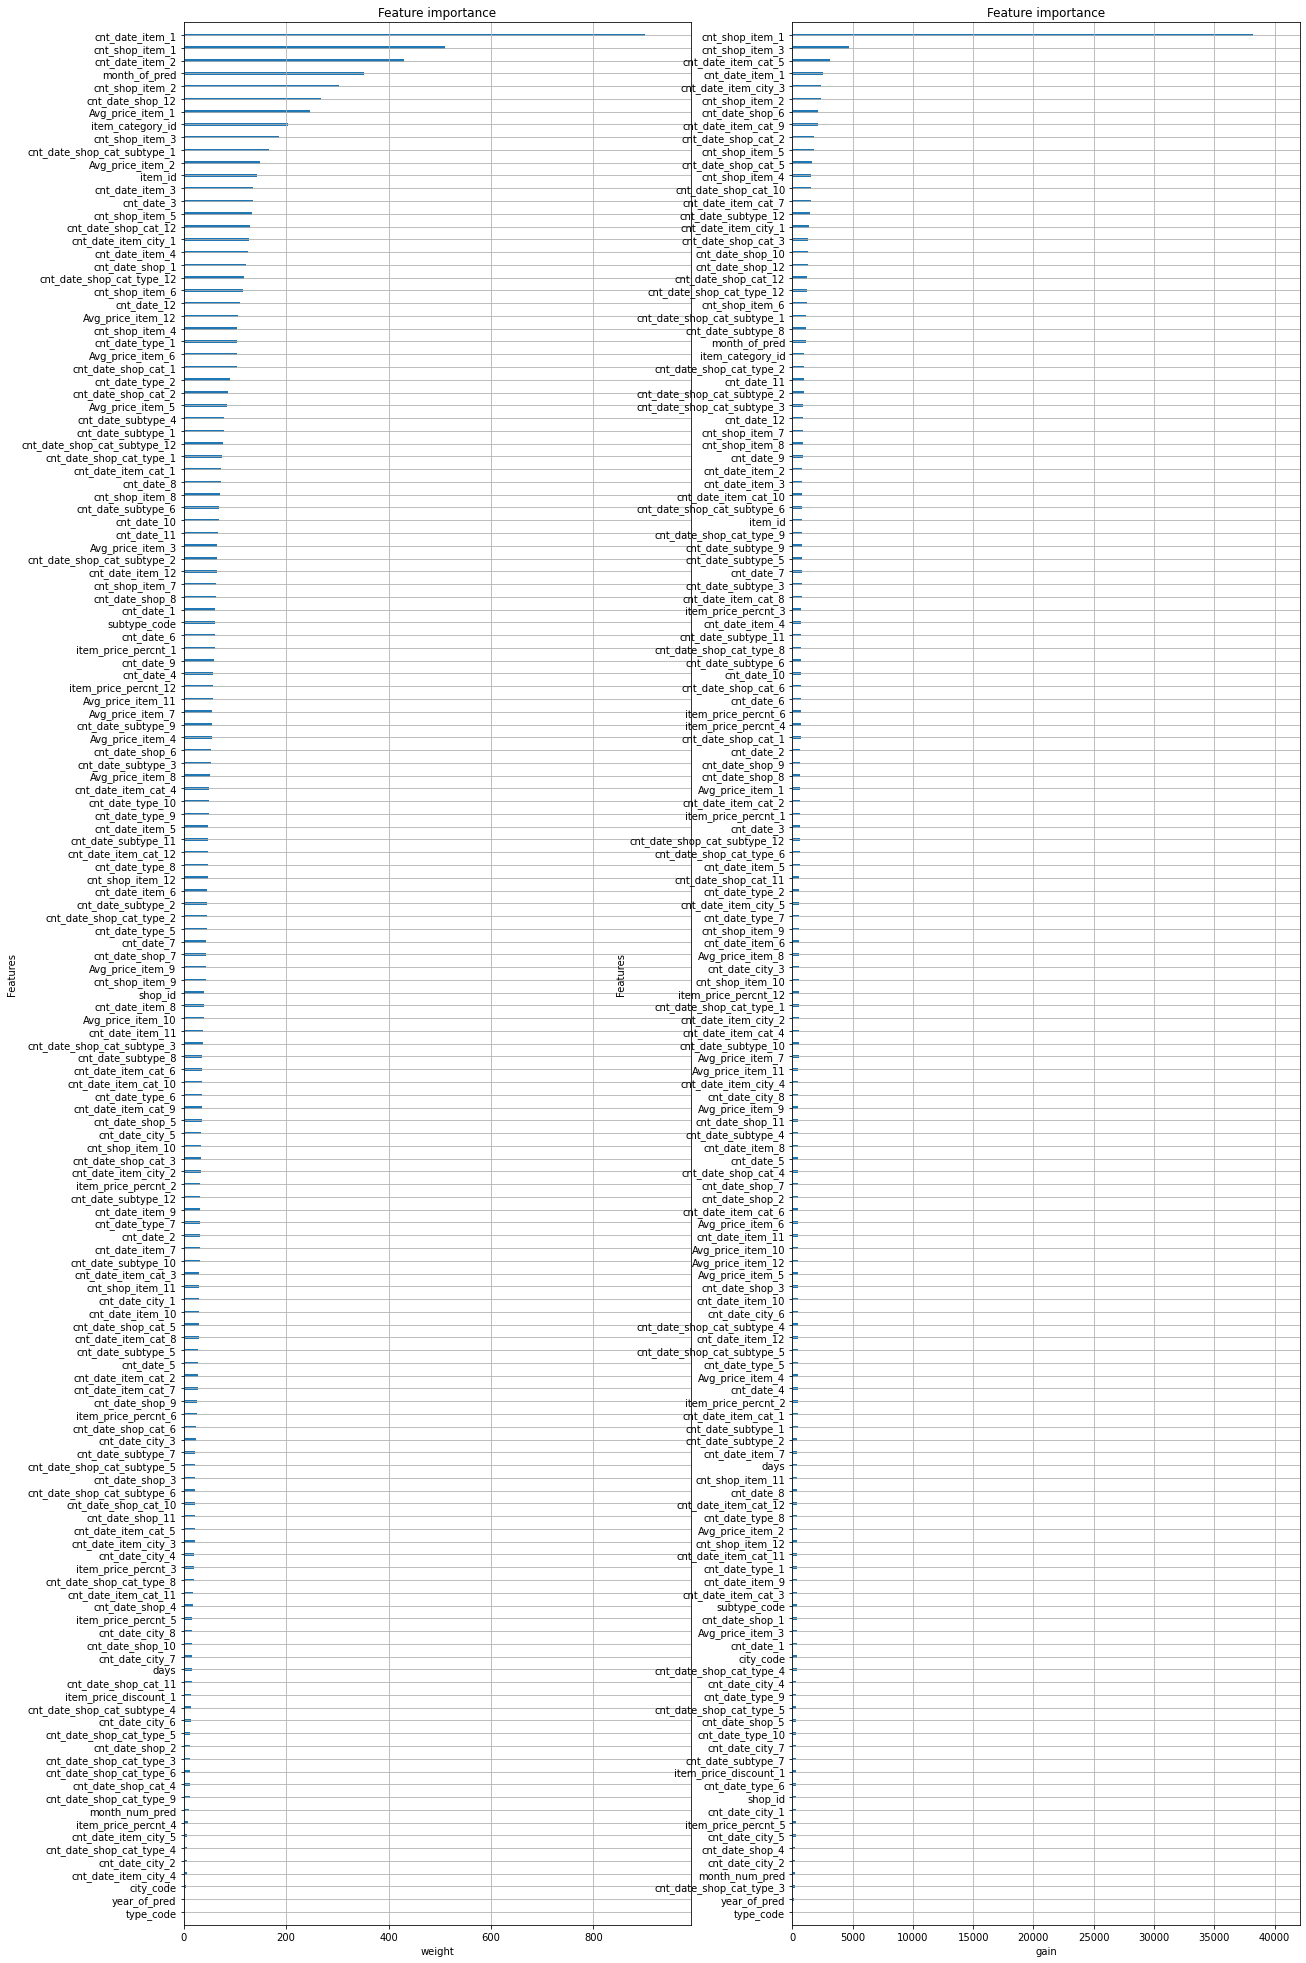

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,35))
xgb.plot_importance(booster=model, ax=ax[0], importance_type='weight', show_values=False, xlabel='weight')
xgb.plot_importance(booster=model, ax=ax[1], importance_type='gain', show_values=False, xlabel='gain')


The test set was prepared as part of the trining set and was saved separetely in our bucket. It. is now downloaed back here. Let's prepared it and do a prediction:

In [ ]:
import pandas as pd
pre_test = pd.read_pickle('/content/custom_job_20210516013132/test.pkl')
pre_test.head()

,shop_id,item_id,cnt_shop_item_12,cnt_shop_item_11,cnt_shop_item_10,cnt_shop_item_9,cnt_shop_item_8,cnt_shop_item_7,cnt_shop_item_6,cnt_shop_item_5,cnt_shop_item_4,cnt_shop_item_3,cnt_shop_item_2,cnt_shop_item_1,month_of_pred,year_of_pred,item_category_id,type_code,subtype_code,city_code,cnt_date_12,cnt_date_11,cnt_date_10,cnt_date_9,cnt_date_8,cnt_date_7,cnt_date_6,cnt_date_5,cnt_date_4,cnt_date_3,cnt_date_2,cnt_date_1,cnt_date_item_12,cnt_date_item_11,cnt_date_item_10,cnt_date_item_9,cnt_date_item_8,cnt_date_item_7,cnt_date_item_6,cnt_date_item_5,...,cnt_date_type_8,cnt_date_type_7,cnt_date_type_6,cnt_date_type_5,cnt_date_type_2,cnt_date_type_1,cnt_date_subtype_12,cnt_date_subtype_11,cnt_date_subtype_10,cnt_date_subtype_9,cnt_date_subtype_8,cnt_date_subtype_7,cnt_date_subtype_6,cnt_date_subtype_5,cnt_date_subtype_4,cnt_date_subtype_3,cnt_date_subtype_2,cnt_date_subtype_1,Avg_price_item_12,Avg_price_item_11,Avg_price_item_10,Avg_price_item_9,Avg_price_item_8,Avg_price_item_7,Avg_price_item_6,Avg_price_item_5,Avg_price_item_4,Avg_price_item_3,Avg_price_item_2,Avg_price_item_1,item_price_percnt_12,item_price_percnt_6,item_price_percnt_5,item_price_percnt_4,item_price_percnt_3,item_price_percnt_2,item_price_percnt_1,item_price_discount_1,month_num_pred,days
0,0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.260010,0.320068,0.280029,0.280029,0.099976,0.080017,0.099976,0.080017,...,0.116272,0.09491,0.078796,0.079834,0.063416,0.073486,0.132446,0.164429,0.133911,0.107971,0.116089,0.093628,0.082397,0.083191,0.083313,0.076477,0.061066,0.069092,-0.200562,-0.201294,-0.201294,-0.200684,-0.200684,-0.200684,-0.200684,-0.213501,-0.216797,-0.232910,-0.236084,-0.239380,0.001689,0.001689,0.001689,0.001689,0.001689,0.001689,0.001689,0.0,34,30
1,0,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,37,11,1,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.207520,0.339600,0.471680,0.245239,0.226440,0.245239,0.094360,0.188721,...,0.116272,0.09491,0.078796,0.079834,0.063416,0.073486,0.120300,0.179443,0.132690,0.107422,0.118408,0.100220,0.074646,0.077393,0.070740,0.072510,0.071350,0.087708,-0.080505,-0.080872,-0.117920,-0.132080,-0.132080,-0.132812,-0.130981,-0.138184,-0.143799,-0.338867,-0.362061,-0.294678,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.0,34,30
2,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.547363,0.754883,0.792480,0.604004,0.754883,0.377441,0.377441,0.490479,...,0.116272,0.09491,0.078796,0.079834,0.063416,0.073486,0.132446,0.164429,0.133911,0.107971,0.116089,0.093628,0.082397,0.083191,0.083313,0.076477,0.061066,0.069092,-0.212280,-0.211914,-0.212158,-0.212280,-0.212158,-0.212158,-0.212158,-0.212158,-0.212158,-0.212891,-0.212891,-0.212891,0.001409,0.001409,0.001409,0.001409,0.001409,0.001409,0.001409,0.0,34,30
3,0,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,37,11,1,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.370361,0.388916,0.351807,0.481445,0.370361,0.240723,0.222168,0.203735,...,0.116272,0.09491,0.078796,0.079834,0.063416,0.073486,0.120300,0.179443,0.132690,0.107422,0.118408,0.100220,0.074646,0.077393,0.070740,0.072510,0.071350,0.087708,-0.145020,-0.145020,-0.145020,-0.145020,-0.145264,-0.145264,-0.145264,-0.145264,-0.145264,-0.145264,-0.148193,-0.148193,0.003349,0.003349,0.003349,0.003349,0.003349,0.003349,0.003349,0.0,34,30
4,0,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.116272,0.09491,0.078796,0.

In [ ]:
pre_test.shape

(424123, 148)

Attach the prediction:

In [ ]:
test_pred = model.predict(xgb.DMatrix(pre_test))
pre_test['item_cnt_month'] = test_pred
pre_test



,shop_id,item_id,cnt_shop_item_12,cnt_shop_item_11,cnt_shop_item_10,cnt_shop_item_9,cnt_shop_item_8,cnt_shop_item_7,cnt_shop_item_6,cnt_shop_item_5,cnt_shop_item_4,cnt_shop_item_3,cnt_shop_item_2,cnt_shop_item_1,month_of_pred,year_of_pred,item_category_id,type_code,subtype_code,city_code,cnt_date_12,cnt_date_11,cnt_date_10,cnt_date_9,cnt_date_8,cnt_date_7,cnt_date_6,cnt_date_5,cnt_date_4,cnt_date_3,cnt_date_2,cnt_date_1,cnt_date_item_12,cnt_date_item_11,cnt_date_item_10,cnt_date_item_9,cnt_date_item_8,cnt_date_item_7,cnt_date_item_6,cnt_date_item_5,...,cnt_date_type_7,cnt_date_type_6,cnt_date_type_5,cnt_date_type_2,cnt_date_type_1,cnt_date_subtype_12,cnt_date_subtype_11,cnt_date_subtype_10,cnt_date_subtype_9,cnt_date_subtype_8,cnt_date_subtype_7,cnt_date_subtype_6,cnt_date_subtype_5,cnt_date_subtype_4,cnt_date_subtype_3,cnt_date_subtype_2,cnt_date_subtype_1,Avg_price_item_12,Avg_price_item_11,Avg_price_item_10,Avg_price_item_9,Avg_price_item_8,Avg_price_item_7,Avg_price_item_6,Avg_price_item_5,Avg_price_item_4,Avg_price_item_3,Avg_price_item_2,Avg_price_item_1,item_price_percnt_12,item_price_percnt_6,item_price_percnt_5,item_price_percnt_4,item_price_percnt_3,item_price_percnt_2,item_price_percnt_1,item_price_discount_1,month_num_pred,days,item_cnt_month
0,0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.260010,0.320068,0.280029,0.280029,0.099976,0.080017,0.099976,0.080017,...,0.094910,0.078796,0.079834,0.063416,0.073486,0.132446,0.164429,0.133911,0.107971,0.116089,0.093628,0.082397,0.083191,0.083313,0.076477,0.061066,0.069092,-0.200562,-0.201294,-0.201294,-0.200684,-0.200684,-0.200684,-0.200684,-0.213501,-0.216797,-0.232910,-0.236084,-0.239380,0.001689,0.001689,0.001689,0.001689,0.001689,0.001689,0.001689,0.0,34,30,0.011463
1,0,31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,37,11,1,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.207520,0.339600,0.471680,0.245239,0.226440,0.245239,0.094360,0.188721,...,0.094910,0.078796,0.079834,0.063416,0.073486,0.120300,0.179443,0.132690,0.107422,0.118408,0.100220,0.074646,0.077393,0.070740,0.072510,0.071350,0.087708,-0.080505,-0.080872,-0.117920,-0.132080,-0.132080,-0.132812,-0.130981,-0.138184,-0.143799,-0.338867,-0.362061,-0.294678,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.004189,0.0,34,30,0.035845
2,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.547363,0.754883,0.792480,0.604004,0.754883,0.377441,0.377441,0.490479,...,0.094910,0.078796,0.079834,0.063416,0.073486,0.132446,0.164429,0.133911,0.107971,0.116089,0.093628,0.082397,0.083191,0.083313,0.076477,0.061066,0.069092,-0.212280,-0.211914,-0.212158,-0.212280,-0.212158,-0.212158,-0.212158,-0.212158,-0.212158,-0.212891,-0.212891,-0.212891,0.001409,0.001409,0.001409,0.001409,0.001409,0.001409,0.001409,0.0,34,30,0.049720
3,0,33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,37,11,1,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.370361,0.388916,0.351807,0.481445,0.370361,0.240723,0.222168,0.203735,...,0.094910,0.078796,0.079834,0.063416,0.073486,0.120300,0.179443,0.132690,0.107422,0.118408,0.100220,0.074646,0.077393,0.070740,0.072510,0.071350,0.087708,-0.145020,-0.145020,-0.145020,-0.145020,-0.145264,-0.145264,-0.145264,-0.145264,-0.145264,-0.145264,-0.148193,-0.148193,0.003349,0.003349,0.003349,0.003349,0.003349,0.003349,0.003349,0.0,34,30,0.031259
4,0,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11,2015,40,11,4,29,0.232056,0.345703,0.229736,0.186646,0.18103,0.147461,0.142212,0.139771,0.139893,0.14563,0.135986,0.145142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.094910,0.078796,0.07983

In [ ]:
pre_test.item_cnt_month.sort_values()

232007    -0.221813
141126    -0.221813
4102      -0.218450
804       -0.218450
51248     -0.198430
            ...    
228118    18.736197
230428    18.850275
384774    19.098307
384775    19.098307
384776    19.098307
Name: item_cnt_month, Length: 424123, dtype: float32

In [ ]:
test = pd.read_csv('/content/data/test.csv.zip')
print(test.shape)
test = test.merge(pre_test[['shop_id','item_id', 'item_cnt_month']], on=['shop_id', 'item_id'], how='left')
print(test.shape)

(214200, 3)
(214200, 4)


In [ ]:
test

,ID,shop_id,item_id,item_cnt_month
0,0,5,5037,0.564082
1,1,5,5320,NaN
2,2,5,5233,0.913160
3,3,5,5232,0.616075
4,4,5,5268,NaN
...,...,...,...,...
214195,214195,45,18454,0.050729
214196,214196,45,16188,NaN
214197,214197,45,15757,0.102495
214198,214198,45,19648,NaN


About 48% of (item_id,shop_id) in our test set does not exist in the train set. So we manually set the prediction for these items to be zero.

In [ ]:
sum(test.item_cnt_month.isna())

102796

In [ ]:
test.fillna(0)[['ID', 'item_cnt_month']].to_csv('submition.csv', index=False)

Finally, we submit the result to the Kaggle platform:

In [ ]:
!kaggle competitions submit -c competitive-data-science-predict-future-sales -f /content/submition.csv -m 'S1'

100% 2.87M/2.87M [00:02<00:00, 1.17MB/s]
Successfully submitted to Predict Future Sales

If we would like to deploy the model for serving predictions, we need to create an Endpoint first and then deploy the model to this endpoint. Next, a prediction request is sent to the endpoint to recieve the prediction. As a guide, refer to a notebook [here](https://cloud.google.com/vertex-ai/docs/training/create-custom-job)

### Create an `Endpoint`

Use the helper function `create_endpoint` to create an `Endpoint` to deploy the `Model` to for serving predictions, with the following parameter:

- `display_name`: A human readable name for the `Endpoint`.

The helper function uses the endpoint client service's `create_endpoint` method, which takes the parameter:

- `display_name`: A human readable name for the `Endpoint`.

Creating an `Endpoint` returns a long-running operation, since it might take a few moments to provision the endpoint for serving. You will call `response.result()`, which is a synchronous call and will return when the `Endpoint` is ready. The helper function returns the AI Platform fully qualified identifier for the `Endpoint` in the `response.name` field.


In [ ]:
ENDPOINT_NAME = "cifar10_endpoint-" + TIMESTAMP


def create_endpoint(display_name):
    endpoint = {"display_name": display_name}
    response = clients["endpoint"].create_endpoint(parent=PARENT, endpoint=endpoint)
    print("Long running operation:", response.operation.name)

    result = response.result(timeout=300)
    print("result")
    print(" name:", result.name)
    print(" display_name:", result.display_name)
    print(" description:", result.description)
    print(" labels:", result.labels)
    print(" create_time:", result.create_time)
    print(" update_time:", result.update_time)
    return result.name


endpoint_name = create_endpoint(ENDPOINT_NAME)

### Prediction scaling

You have several choices on scaling the VMs for handling your online prediction requests:

- Single Instance: The online prediction requests are processed on a single VM.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of compute instances to one. 


- Manual Scaling: The online prediction requests are split across a fixed number of VMs that you manually specified.
  - Set the minimum (`MIN_NODES`) and maximum (`MAX_NODES`) number of VMs to the same number of nodes. When a `Model` is first deployed to `Endpoint`, the fixed number of compute instances are provisioned and online prediction requests are evenly distributed across them.
  

- Auto Scaling: The online prediction requests are streamed across an initial number of VMs. Based on time and compute tradeoffs, AI Platform might automatically scale your `DeployedModel` to provision and deprovision compute instances.
  - Set the minimum (`MIN_NODES`) to the initial number of VMs and the maximum (`MAX_NODES`) to the maximum number of VMs that you want the service to scale to.
  
The minimum number of VMs corresponds to the field `min_replica_count` and the maximum number of VMs corresponds to the field `max_replica_count`.

In [ ]:
MIN_NODES = 1
MAX_NODES = 1

### Deploy model to the endpoint

Use the helper function `deploy_model` to deploy the `Model` to the `Endpoint` you created for serving predictions, with the following parameters:

- `model`: The AI Platform fully qualified identifier of the `Model` to deploy.
- `deployed_model_display_name`: A human readable name for the `DeployedModel`.
- `endpoint`: The AI Platform fully qualified `Endpoint` identifier to deploy the `Model` to.

The helper function calls the endpoint client service's `deploy_model` method, which takes the following parameters:

- `endpoint`: The AI Platform fully qualified `Endpoint` identifier to deploy the `Model` to.
- `deployed_model`: The requirements for deploying the `Model`.
- `traffic_split`: Percent of the `Endpoint`'s traffic that you want to go to this `DeployedModel`. This is specified as a dictionary of one or more key/value pairs.
   - If only one model, then specify as **{ "0": 100 }**, where "0" refers to the new `DeployedModel` and 100 means 100% of the traffic.
   - If there are existing models on the endpoint, for which the traffic will be split, then specify as follows, where `model_id` is the model id of an existing model to the deployed endpoint. The percents must add up to 100.
   
           { "0": percent, model_id: percent, ... }

The `deployed_model` parameter is specified as a Python dictionary with the minimum required fields:

- `model`: The AI Platform fully qualified identifier of the `Model` to deploy.
- `display_name`: A human readable name for the `DeployedModel`.
- `dedicated_resources`: This refers to how many VMs (replicas) are scaled for serving prediction requests.  
  - `machine_spec`: The compute resources to provision for each VM. Use the variable you set earlier: `DEPLOY_GPU != None` to use a GPU; otherwise only a CPU is allocated.  
  - `min_replica_count`: The number of VMs to initially provision, which you set earlier as the variable `MIN_NODES`.
  - `max_replica_count`: The maximum number of VMs to scale to, which you set earlier as the variable `MAX_NODES`.
- `enable_container_logging`: This enables logging of container events, such as execution failures. The default is False. This is typically set to True when debugging the deployment and then set to False when deployed for production.


Configuring the `traffic_split` to split traffic between multiple `DeployedModel` resources might be helpful in a situation like the following: Perhaps you already have a previous version of your model deployed in production as a `DeployedModel` called `v1`. You got better model evaluation on a new model, which you will deploy as `v2`, but you don't know for certain that it is really better until you deploy to production. So in the case of traffic split, you might want to deploy `v2` to the same `Endpoint` as `v1` but only allocate it 10% of the traffic. That way, you can monitor how well it does without disrupting the majority of users -- until you make a final decision.

In [ ]:
DEPLOYED_NAME = "cifar10_deployed-" + TIMESTAMP


def deploy_model(
    model, deployed_model_display_name, endpoint, traffic_split={"0": 100}
):

    if DEPLOY_GPU:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_type": DEPLOY_GPU,
            "accelerator_count": DEPLOY_NGPU,
        }
    else:
        machine_spec = {
            "machine_type": DEPLOY_COMPUTE,
            "accelerator_count": 0,
        }

    deployed_model = {
        "model": model,
        "display_name": deployed_model_display_name,
        "dedicated_resources": {
            "min_replica_count": MIN_NODES,
            "max_replica_count": MAX_NODES,
            "machine_spec": machine_spec,
        },
    }

    response = clients["endpoint"].deploy_model(
        endpoint=endpoint, deployed_model=deployed_model, traffic_split=traffic_split
    )

    print("Long running operation:", response.operation.name)
    result = response.result()
    print("result")
    deployed_model = result.deployed_model
    print(" deployed_model")
    print("  id:", deployed_model.id)
    print("  model:", deployed_model.model)
    print("  display_name:", deployed_model.display_name)
    print("  create_time:", deployed_model.create_time)

    return deployed_model.id


deployed_model_id = deploy_model(model_to_deploy_name, DEPLOYED_NAME, endpoint_name)

### List all endpoints

Get a list of all your `Endpoint` resources. Use the helper function `list_endpoints`. 

The helper function calls the endpoint client service's `list_endpoints` method. The returned response object is a list, with an element for each `Endpoint`. The helper function prints a few example fields for each `Endpoint`:

- `name`: The AI Platform identifier for the `Endpoint`.
- `display_name`: The human readable name you assigned to the `Endpoint`.
- `create_time`: When the `Endpoint` was created.
- `deployed_models`: The `DeployedModel`s and associated information that are deployed to this `Endpoint`.

In [ ]:
def list_endpoints():
    response = clients["endpoint"].list_endpoints(parent=PARENT)
    for endpoint in response:
        print("name:", endpoint.name)
        print("display name:", endpoint.display_name)
        print("create_time:", endpoint.create_time)
        print("deployed_models", endpoint.deployed_models)
        print("\n")


list_endpoints()

### Get information on this endpoint

Get informationfor just your endpoint. Use the helper function `get_endpoint`, with the following parameter:

- `name`: The AI Platform unique identifier for the `Endpoint`.

This helper function calls the endpoint client service's `get_endpoint` method, with the following parameter:

- `name`: The AI Platform unique identifier for the managed `Endpoint`.

In [ ]:
def get_endpoint(name):
    response = clients["endpoint"].get_endpoint(name=name)
    print(response)


get_endpoint(endpoint_name)

## Make a prediction request

Let's now get a prediction from the `Endpoint`. You will use an arbitrary image out of the test (holdout) portion of the dataset as a test image. 

In [ ]:
test_image = x_test[0]
test_label = y_test[0]
print(test_image.shape)

### Prepare the request content
You are going to send the CIFAR10 image as compressed JPG image, instead of the raw uncompressed bytes:

- `cv2.imwrite`: Use openCV to write the uncompressed image to disk as a compressed JPEG image.
- `tf.io.read_file`: Read the compressed JPG images back into memory as raw bytes.
- `base64.b64encode`: Encode the raw bytes into a base64-encoded string.

In [ ]:
import base64

from PIL import Image

image = Image.fromarray((test_image * 255).astype(np.uint8))
image.save("tmp.jpg")

bytes = tf.io.read_file("tmp.jpg")
b64str = base64.b64encode(bytes.numpy()).decode("utf-8")

### Send the prediction request

To send a prediction request, use the helper function `predict_image`, which takes the following parameters:

- `image`: The test image data as a numpy array.
- `endpoint`: The AI Platform fully qualified identifier for the `Endpoint`.
- `parameters_dict`: Additional parameters for serving -- in this case, None.

This function calls the prediction client service's `predict` method with the following parameters:

- `endpoint`: The AI Platform fully qualified identifier for the `Endpoint`.
- `instances`: A list of instances (encoded images) to predict.
- `parameters`: Additional parameters for serving -- in this case, None.

To pass the image data to the prediction service, in the previous step you encoded the bytes into base 64 -- which makes the content safe from modification when transmitting binary data over the network. You need to tell the pre-built container that the content has been base64-encoded, so it will decode the on the other end before passing it to your TensorFlow graph. 

Each instance in the prediction request is a dictionary with the following form:

                        {input_name: {'b64': content}}
                        
- `input_name`: the name of the input layer of the underlying model.
- `'b64'`: A key that indicates the content is base64-encoded.
- `content`: The compressed JPEG image bytes as a base64-encoded string.

Since the `predict()` service can take multiple images (instances), you will send your single image as a list of one image. As a final step, you package the instances list into Google's protobuf format; this is what you pass to the `predict()` service.

The `response` object returns a list, where each element in the list corresponds to the corresponding image in the request. You will see in the output for each prediction:

- Confidence level for the prediction (`predictions`), between 0 and 1, for each of the ten classes.

In [ ]:
def predict_image(image, endpoint, parameters_dict):
    # The format of each instance should conform to the deployed model's prediction input schema.
    instances_list = [{input_name: {"b64": image}}]
    instances = [json_format.ParseDict(s, Value()) for s in instances_list]

    response = clients["prediction"].predict(
        endpoint=endpoint, instances=instances, parameters=parameters_dict
    )
    print("response")
    print(" deployed_model_id:", response.deployed_model_id)
    predictions = response.predictions
    print("predictions")
    for prediction in predictions:
        # See gs://google-cloud-aiplatform/schema/predict/prediction/classification.yaml for the format of the predictions.
        print(" prediction:", prediction)


predict_image(b64str, endpoint_name, None)

## Undeploy the model

Undeploy your `DeployedModel` from the serving `Endpoint`. Use the helper function `undeploy_model`, which takes the following parameters:

- `deployed_model_id`: The `DeployedModel` identifier returned by the `Endpoint` service when you deployed the `Model` as a `DeployedModel`.
- `endpoint`: The AI Platform fully qualified identifier for the `Endpoint` where the `DeployedModel` is deployed.

This function calls the endpoint client service's `undeploy_model` method, with the following parameters:

- `deployed_model_id`: The `DeployedModel` identifier returned by the `Endpoint` service when you dep
- `endpoint`: The AI Platform fully qualified identifier for the `Endpoint` where the `DeployedModel` is deployed.
- `traffic_split`: How to split traffic among the remaining `DeployedModel`s on the `Endpoint`.

Since this is the only `DeployedModel` on the `Endpoint`, you can leave `traffic_split` empty by setting it to {}.

In [ ]:
def undeploy_model(deployed_model_id, endpoint):
    response = clients["endpoint"].undeploy_model(
        endpoint=endpoint, deployed_model_id=deployed_model_id, traffic_split={}
    )
    print(response)


undeploy_model(deployed_model_id, endpoint_name)

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

- Dataset
- Model
- Endpoint
- Cloud Storage Bucket

In [ ]:
delete_dataset = True
delete_model = True
delete_endpoint = True
delete_bucket = True

# Delete the dataset using the AI Platform (Unified) fully qualified identifier for the dataset
try:
    if delete_dataset:
        clients["dataset"].delete_dataset(name=dataset["name"])
except Exception as e:
    print(e)

# Delete the model using the AI Platform (Unified) fully qualified identifier for the model
try:
    if delete_model:
        clients["model"].delete_model(name=model_to_deploy_name)
except Exception as e:
    print(e)

# Delete the endpoint using the AI Platform (Unified) fully qualified identifier for the endpoint
try:
    if delete_endpoint:
        clients["endpoint"].delete_endpoint(name=endpoint_name)
except Exception as e:
    print(e)

if delete_bucket and "BUCKET_NAME" in globals():
    ! gsutil rm -r gs://$BUCKET_NAME

# Collect any unclaimed memory
import gc

gc.collect()

In [ ]:
# def prep_dataset(data, lags, lag_name, with_label=True):
#     '''Creates lags of given names and a series of rows of data, each aiming 
#     to target a label, which is item count in a month.'''
#     lag_length = max(lags)
#     columns = []
#     # Column names
#     lag_title = ['{}_{}'.format(lag_name, i+1) for i in range(lag_length)]
#     columns.extend(['shop_id', 'item_id'])
#     columns.extend(lag_title)
#     columns.extend(['month_of_pred', 'year_of_pred'])
#     if with_label: columns.extend(['label'])
#     prep_data = pd.DataFrame()
#     length = data.shape[0]
#     n = length - lag_length
#     for i in range(0,n):
#         df1 = pd.DataFrame(data.T.reset_index()[['shop_id', 'item_id']].values, columns=['shop_id', 'item_id'])
#         # Lag features are attached to (item_id, shop_id) pairs 
#         df1 = pd.concat([df1, pd.DataFrame(data[length-1-i-lag_length: length-1-i].T.values, dtype='float16')], axis=1, ignore_index=True)
#         # Create month and year of the label being predicted - attach it to df1
#         df2 = pd.DataFrame({
#                             'month_of_pred': [data[length-i-1: length-i].index.values[0]%12+1]*df1.shape[0],
#                             'year_of_pred': [yer(data[length-i-1: length-i].index.values[0])]*df1.shape[0]
#                             }, dtype='int16')
#         # Add label only for item_cnt records
#         if with_label:
#             df3 = pd.DataFrame({'label':data[length-i-1: length-i].T.values.reshape(-1)},dtype='float16')
#             prep_data = prep_data.append(pd.concat([df1, df2, df3], axis=1, ignore_index=True))
#         else: 
#             prep_data = prep_data.append(pd.concat([df1, df2], axis=1, ignore_index=True))
        
#     prep_data.columns = columns
#     drop = ['{}_{}'.format(lag_name, i) for i in lags]
#     prep_data.drop(drop, axis=1, inplace=True)
#     return prep_data